#### Question: Are there any specific services or products that are more commonly associated with each reason category for churn? then, How well can we predict the churn reason category based on the services and products that a customer has?

##### Expectations:
analyzing the specific services or products that are commonly associated with each reason category for churn can provide valuable insights for the business. For example, if customers are churning due to issues with internet speed, the company may need to invest in improving their network infrastructure. If customers are churning due to high prices, the company may need to consider adjusting their pricing strategy or offering more affordable packages. By understanding the specific services or products that are driving customer churn, the company can make targeted improvements to reduce churn rates and improve customer satisfaction. Additionally, this information can inform the development of new products or services that better meet the needs and preferences of customers.

#### EDA:

In [213]:
# Importing the libraries
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from imblearn.over_sampling import ADASYN, BorderlineSMOTE
from collections import Counter

In [214]:
# Load the data from /Dataset/Telco_customer_churn_services.xlsx
dataset1 = pd.read_excel('../Dataset/Telco_customer_churn_services.xlsx')

In [215]:
dataset1.columns

Index(['Customer ID', 'Count', 'Quarter', 'Referred a Friend',
       'Number of Referrals', 'Tenure in Months', 'Offer', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue'],
      dtype='object')

In [216]:
my_columns = ['Customer ID', 'Phone Service', 'Internet Service', 'Multiple Lines',
              'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 'Unlimited Data']

dataset1 = dataset1[my_columns]


In [217]:
# we need the churn category from a different file
dataset2 = pd.read_excel('../Dataset/Telco_customer_churn_status.xlsx')

In [218]:
dataset2.columns

Index(['Customer ID', 'Count', 'Quarter', 'Satisfaction Score',
       'Customer Status', 'Churn Label', 'Churn Value', 'Churn Score', 'CLTV',
       'Churn Category', 'Churn Reason'],
      dtype='object')

In [219]:
my_columns = ['Customer ID', 'Churn Category','Churn Label']

dataset2 = dataset2[my_columns]

In [220]:
# merge the two datasets
dataset = pd.merge(dataset1, dataset2, on='Customer ID')

In [221]:
dataset.columns

Index(['Customer ID', 'Phone Service', 'Internet Service', 'Multiple Lines',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Unlimited Data', 'Churn Category',
       'Churn Label'],
      dtype='object')

In [222]:
# Check for messing values
dataset.isnull().sum()

Customer ID                  0
Phone Service                0
Internet Service             0
Multiple Lines               0
Online Security              0
Online Backup                0
Device Protection Plan       0
Premium Tech Support         0
Unlimited Data               0
Churn Category            5174
Churn Label                  0
dtype: int64

In [223]:
Customer_ID = dataset['Customer ID']

We see that churn category is missing some values but we are not sure yet if that is a problem or it is just because the customer did not churn. We will check that.

In [224]:
# make sure that when churn category is missing the churn label is false
dataset[dataset['Churn Category'].isnull()]['Churn Label'].value_counts()

No    5174
Name: Churn Label, dtype: int64

it is indeed the case that the missing values in the churn category are due to the fact that the customer did not churn. We will drop all customers who have not churned because we are only interested in the customers who have churned.

In [225]:
# drop customers who have not churned
dataset = dataset[dataset['Churn Category'].notnull()]

In [226]:
dataset.isnull().sum()

Customer ID               0
Phone Service             0
Internet Service          0
Multiple Lines            0
Online Security           0
Online Backup             0
Device Protection Plan    0
Premium Tech Support      0
Unlimited Data            0
Churn Category            0
Churn Label               0
dtype: int64

In [227]:
# drop the customer ID column
if 'Customer ID' in dataset.columns:
    dataset.drop({'Customer ID','Churn Label'}, axis=1, inplace=True)

In [228]:
dataset.dtypes

Phone Service             object
Internet Service          object
Multiple Lines            object
Online Security           object
Online Backup             object
Device Protection Plan    object
Premium Tech Support      object
Unlimited Data            object
Churn Category            object
dtype: object

In [229]:
# clone the dataset
datasetDummies = dataset.copy()
# turn the categorical variables into dummy variables except for the churn category 
dataset = pd.get_dummies(dataset.drop(
    'Churn Category', axis=1), drop_first=True)

# add the churn category to the dataset
dataset['Churn Category'] = datasetDummies['Churn Category']

# check the data types of the columns
dataset.dtypes


Phone Service_Yes              uint8
Internet Service_Yes           uint8
Multiple Lines_Yes             uint8
Online Security_Yes            uint8
Online Backup_Yes              uint8
Device Protection Plan_Yes     uint8
Premium Tech Support_Yes       uint8
Unlimited Data_Yes             uint8
Churn Category                object
dtype: object

In [230]:
dataset.columns

Index(['Phone Service_Yes', 'Internet Service_Yes', 'Multiple Lines_Yes',
       'Online Security_Yes', 'Online Backup_Yes',
       'Device Protection Plan_Yes', 'Premium Tech Support_Yes',
       'Unlimited Data_Yes', 'Churn Category'],
      dtype='object')

In [231]:
# rename the columns with _Yes to remove the _Yes
if 'Phone Service_Yes' in dataset.columns:
    dataset.rename(columns={'Phone Service_Yes': 'Phone Service',
                            'Internet Service_Yes': 'Internet Service',
                            'Multiple Lines_Yes': 'Multiple Lines',
                            'Online Security_Yes': 'Online Security',
                            'Online Backup_Yes': 'Online Backup',
                            'Device Protection Plan_Yes': 'Device Protection Plan',
                            'Premium Tech Support_Yes': 'Premium Tech Support',
                            'Unlimited Data_Yes': 'Unlimited Data'}, inplace=True)

In [232]:
dataset.head()

,Phone Service,Internet Service,Multiple Lines,Online Security,Online Backup,Device Protection Plan,Premium Tech Support,Unlimited Data,Churn Category
0,0,1,0,0,0,1,0,0,Competitor
1,1,1,1,0,1,0,0,1,Competitor
2,1,1,1,0,0,0,0,1,Competitor
3,1,1,0,0,1,1,0,1,Dissatisfaction
4,1,1,1,0,0,0,0,1,Price


In [233]:
# get unique values for churn category
dataset['Churn Category'].unique()

array(['Competitor', 'Dissatisfaction', 'Price', 'Other', 'Attitude'],
      dtype=object)

##### We have four categories of churn reasons:
1. Competitor offers
2. Price
3. Dissatisfaction with service
4. Attitude of support person
5. Other

In [234]:
# visualize distribution of churn category
counts = dataset['Churn Category'].value_counts(
    normalize=True).rename('Percentage').mul(100).reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(x='index', y='Percentage', data=counts, width=0.5)
plt.title('Distribution of Churn Category')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Churn Category', fontsize=12)
plt.show()

##### Insights:
1. The most common reason for churn is competitor offers, followed by attitude of support person, dissatisfaction with service, and price.

In [235]:
# visualize the distribution of the different services and the churn categories all in one plot
# we are only interested in the customers who have the service hence only consider the 1 values

# plot the phone service distribution normalized by the total count of customers who have the service
plt.figure(figsize=(20, 10))
plt.subplot(2, 4, 1)
counts = dataset[dataset['Phone Service'] == 1]['Churn Category'].value_counts(
    normalize=True).rename('Percentage').mul(100).reset_index()
sns.barplot(x='index', y='Percentage', data=counts, width=0.5)
plt.title('Phone Service Distribution')
plt.ylabel('Percentage')
plt.xlabel('Churn Category')

# plot the internet service distribution normalized by the total count of customers who have the service
plt.subplot(2, 4, 2)
counts = dataset[dataset['Internet Service'] == 1]['Churn Category'].value_counts(
    normalize=True).rename('Percentage').mul(100).reset_index()
sns.barplot(x='index', y='Percentage', data=counts, width=0.5)
plt.title('Internet Service Distribution')
plt.ylabel('Percentage')
plt.xlabel('Churn Category')

# plot the multiple lines distribution normalized by the total count of customers who have the service
plt.subplot(2, 4, 3)
counts = dataset[dataset['Multiple Lines'] == 1]['Churn Category'].value_counts(
    normalize=True).rename('Percentage').mul(100).reset_index()
sns.barplot(x='index', y='Percentage', data=counts, width=0.5)
plt.title('Multiple Lines Distribution')
plt.ylabel('Percentage')
plt.xlabel('Churn Category')

# plot the online security distribution normalized by the total count of customers who have the service
plt.subplot(2, 4, 4)
counts = dataset[dataset['Online Security'] == 1]['Churn Category'].value_counts(
    normalize=True).rename('Percentage').mul(100).reset_index()
sns.barplot(x='index', y='Percentage', data=counts, width=0.5)
plt.title('Online Security Distribution')
plt.ylabel('Percentage')
plt.xlabel('Churn Category')

# plot the online backup distribution normalized by the total count of customers who have the service
plt.subplot(2, 4, 5)
counts = dataset[dataset['Online Backup'] == 1]['Churn Category'].value_counts(
    normalize=True).rename('Percentage').mul(100).reset_index()
sns.barplot(x='index', y='Percentage', data=counts, width=0.5)
plt.title('Online Backup Distribution')
plt.ylabel('Percentage')
plt.xlabel('Churn Category')

# plot the device protection plan distribution normalized by the total count of customers who have the service
plt.subplot(2, 4, 6)
counts = dataset[dataset['Device Protection Plan'] == 1]['Churn Category'].value_counts(
    normalize=True).rename('Percentage').mul(100).reset_index()
sns.barplot(x='index', y='Percentage', data=counts, width=0.5)
plt.title('Device Protection Plan Distribution')
plt.ylabel('Percentage')
plt.xlabel('Churn Category')


# plot the premium tech support distribution normalized by the total count of customers who have the service
plt.subplot(2, 4, 7)
counts = dataset[dataset['Premium Tech Support'] == 1]['Churn Category'].value_counts(
    normalize=True).rename('Percentage').mul(100).reset_index()
sns.barplot(x='index', y='Percentage', data=counts, width=0.5)
plt.title('Premium Tech Support Distribution')
plt.ylabel('Percentage')
plt.xlabel('Churn Category')


# plot the unlimited data distribution normalized by the total count of customers who have the service
plt.subplot(2, 4, 8)
counts = dataset[dataset['Unlimited Data'] == 1]['Churn Category'].value_counts(
    normalize=True).rename('Percentage').mul(100).reset_index()
sns.barplot(x='index', y='Percentage', data=counts, width=0.5)
plt.title('Unlimited Data Distribution')
plt.ylabel('Percentage')
plt.xlabel('Churn Category')

plt.tight_layout()


In [236]:
# Now let's reverse it I want to visualize the distribution churn reason across the different services
def plot_dist(churn_reason):
    # Filter the DataFrame
    reason = dataset[dataset['Churn Category']
                     == churn_reason].drop("Churn Category", axis=1)
    # Reshape the DataFrame to a long format
    df_long = reason.melt(var_name='Column', value_name='Value')

    # Filter the rows where the value is 1
    df_long_ones = df_long[df_long['Value'] == 1]

    # Create a box plot
    plt.figure(figsize=(20, 10))
    sns.countplot(x='Column', data=df_long_ones)
    plt.title('Distribution of Churn Reason for ' + churn_reason)
    plt.ylabel('Number of Occurrences')
    plt.xlabel('Service')

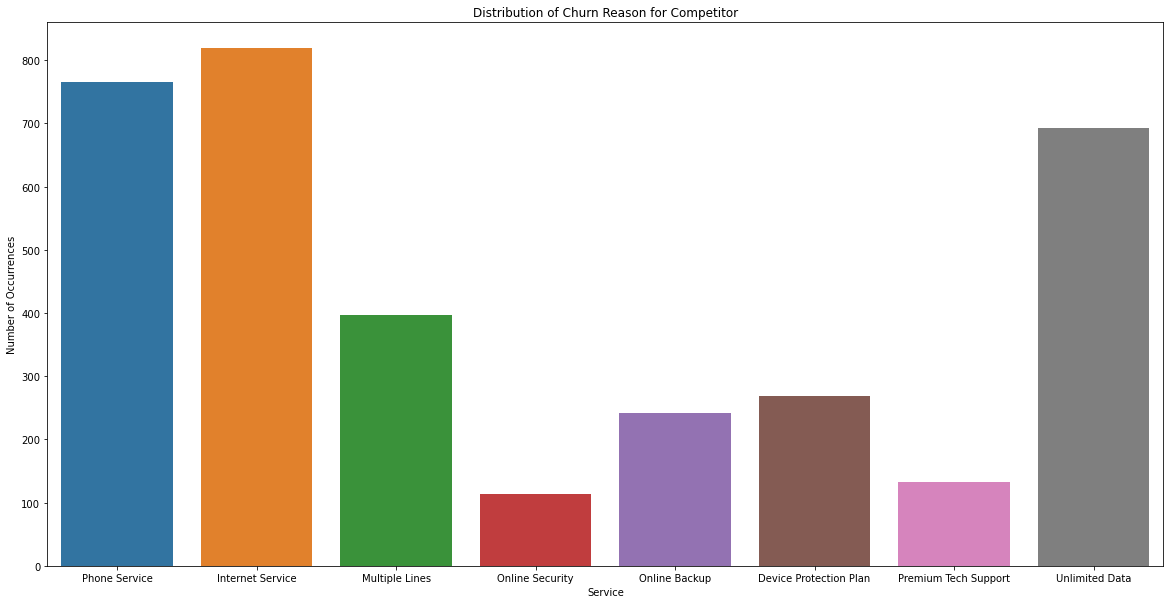

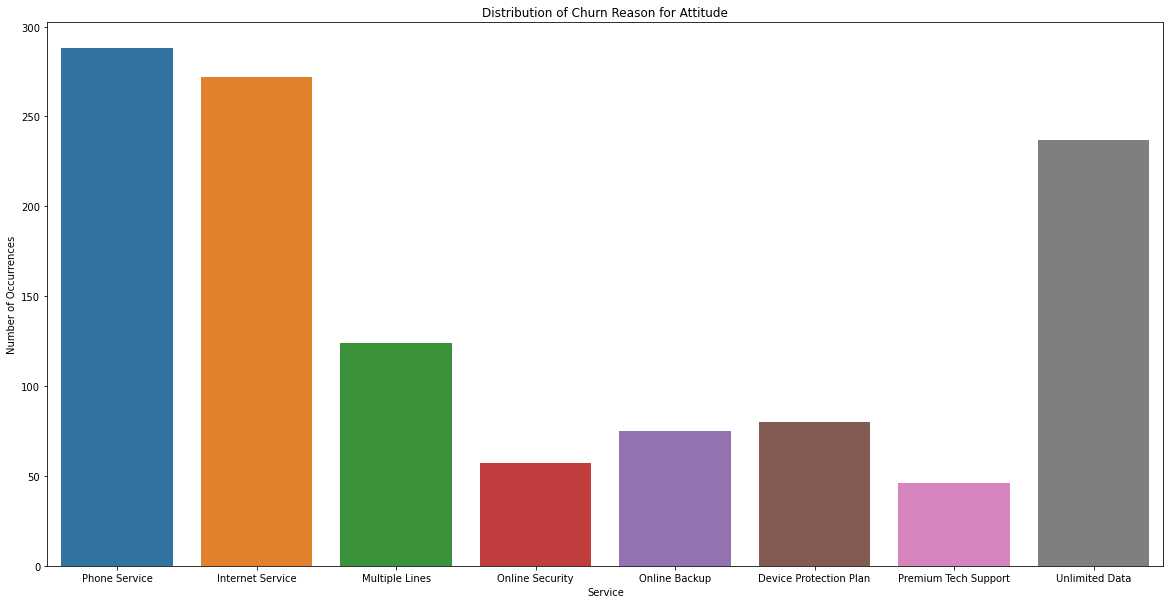

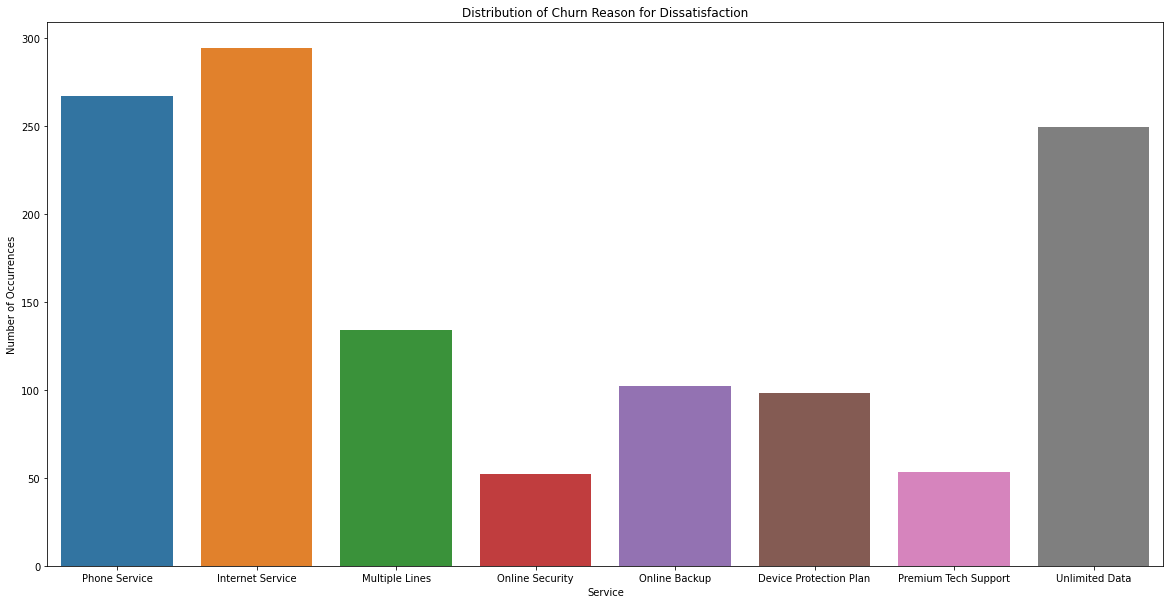

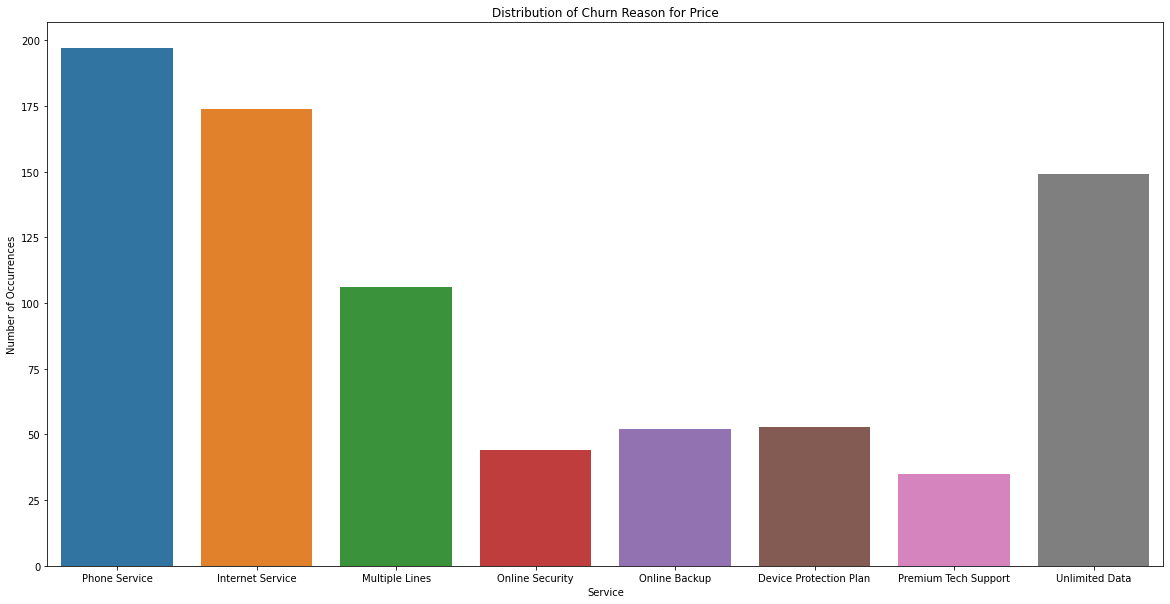

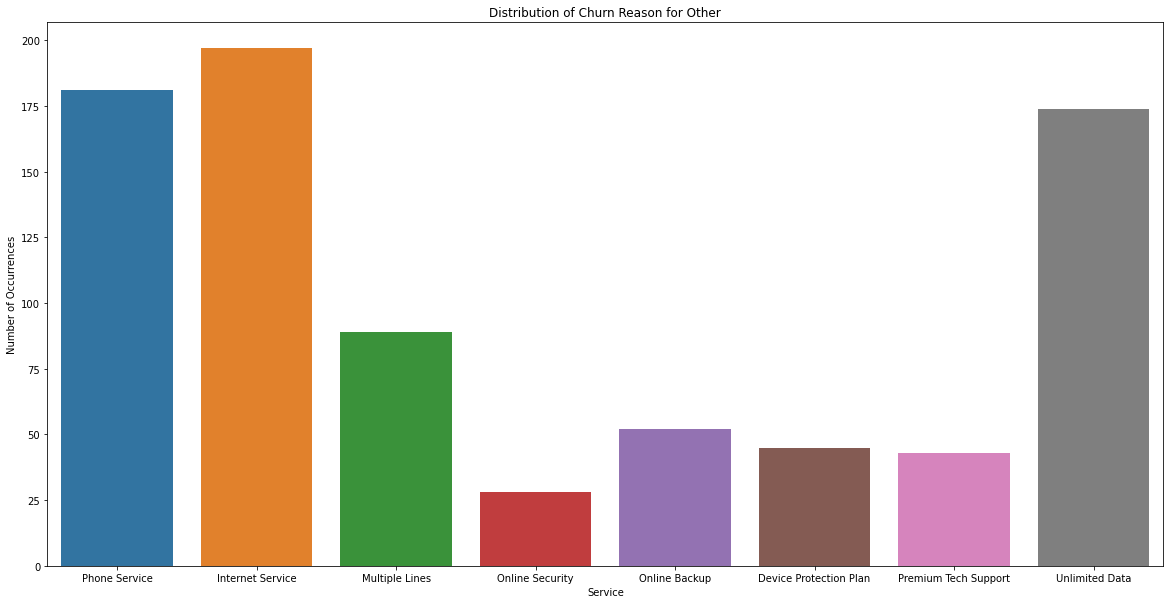

In [237]:
# plot the distribution of churn reason for each churn category 
plot_dist('Competitor')
plot_dist('Attitude')
plot_dist('Dissatisfaction')
plot_dist('Price')
plot_dist('Other')

In [238]:
# turn the churn reason into dummy variables (make a new copy of the dataset)
datasetCorr = pd.get_dummies(dataset, columns=['Churn Category'])
datasetCorr.columns

Index(['Phone Service', 'Internet Service', 'Multiple Lines',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Unlimited Data', 'Churn Category_Attitude',
       'Churn Category_Competitor', 'Churn Category_Dissatisfaction',
       'Churn Category_Other', 'Churn Category_Price'],
      dtype='object')

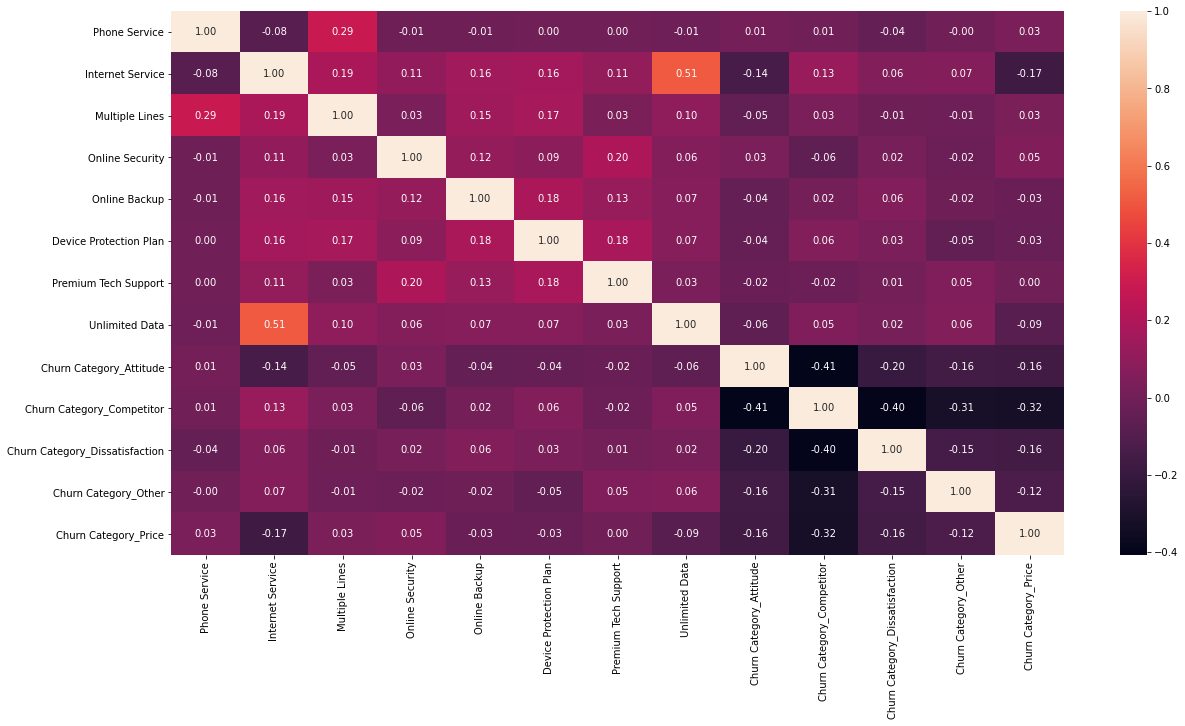

In [239]:
# draw heatmap to visualize the correlation between the different features
plt.figure(figsize=(20, 10))
sns.heatmap(datasetCorr.corr(method='pearson'), annot=True, fmt='.2f')
plt.show()


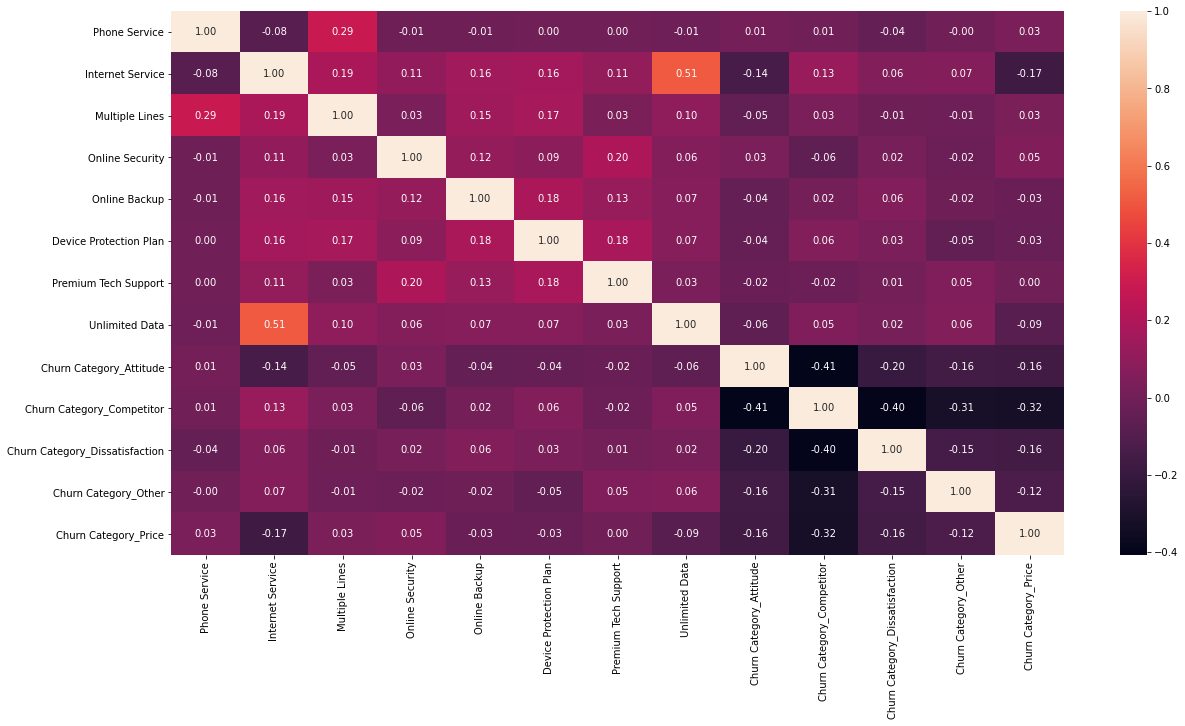

In [240]:
# draw heatmap to visualize the correlation between the different features
plt.figure(figsize=(20, 10))
sns.heatmap(datasetCorr.corr(method='kendall'), annot=True, fmt='.2f')
plt.show()


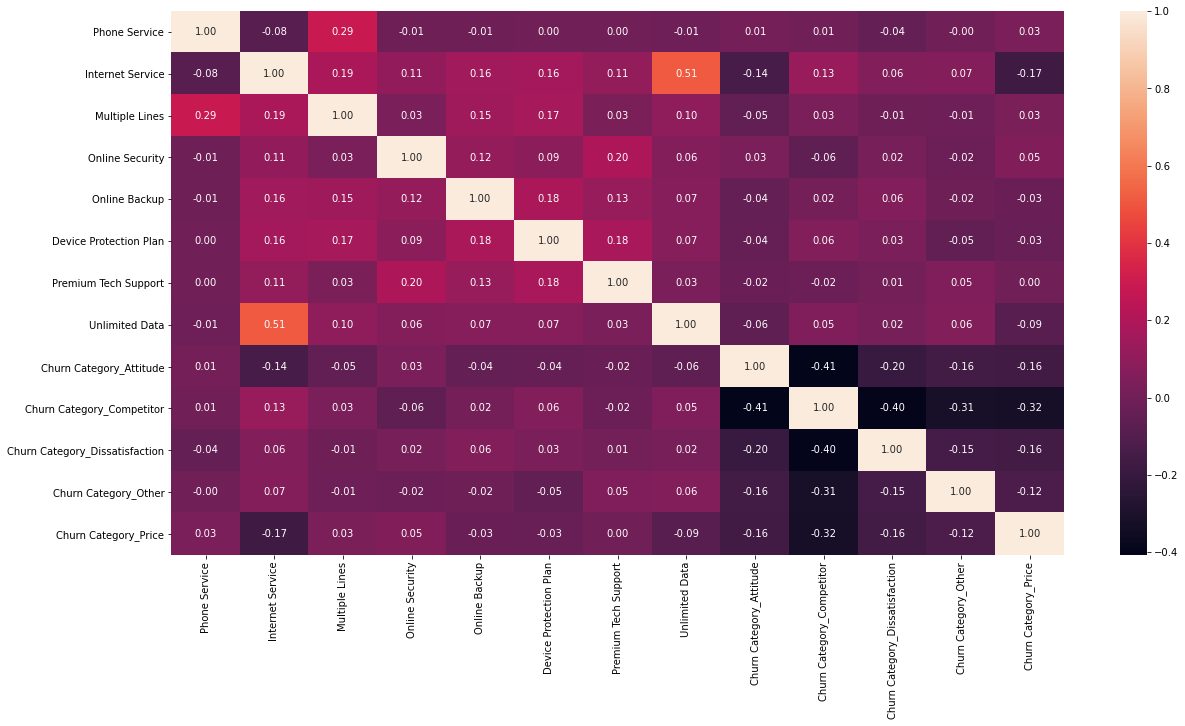

In [241]:
# draw heatmap to visualize the correlation between the different features
plt.figure(figsize=(20, 10))
sns.heatmap(datasetCorr.corr(method='spearman'), annot=True, fmt='.2f')
plt.show()


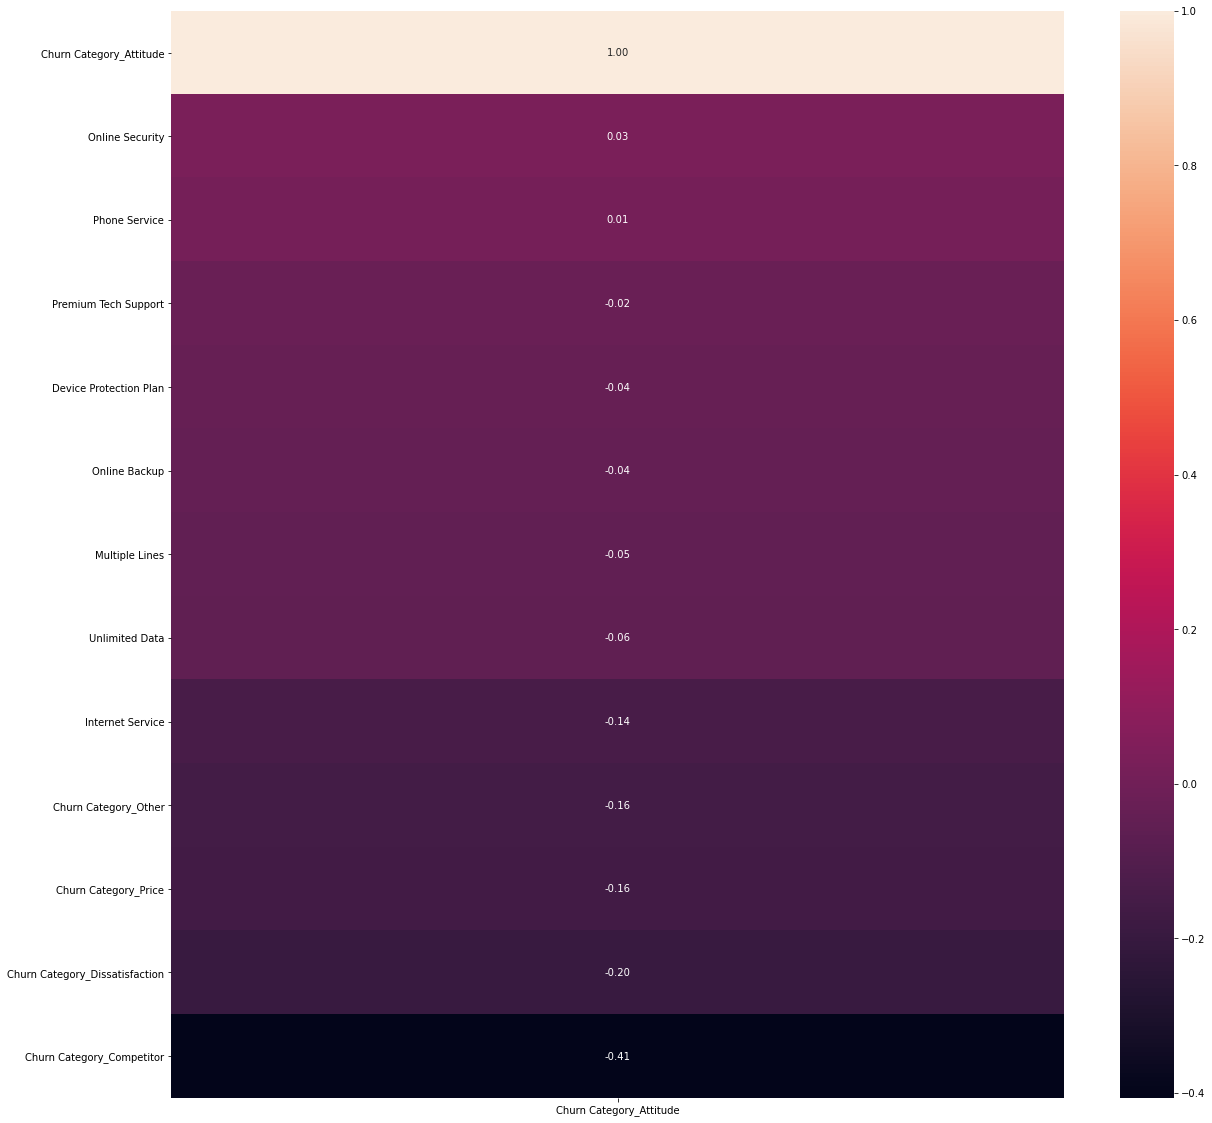

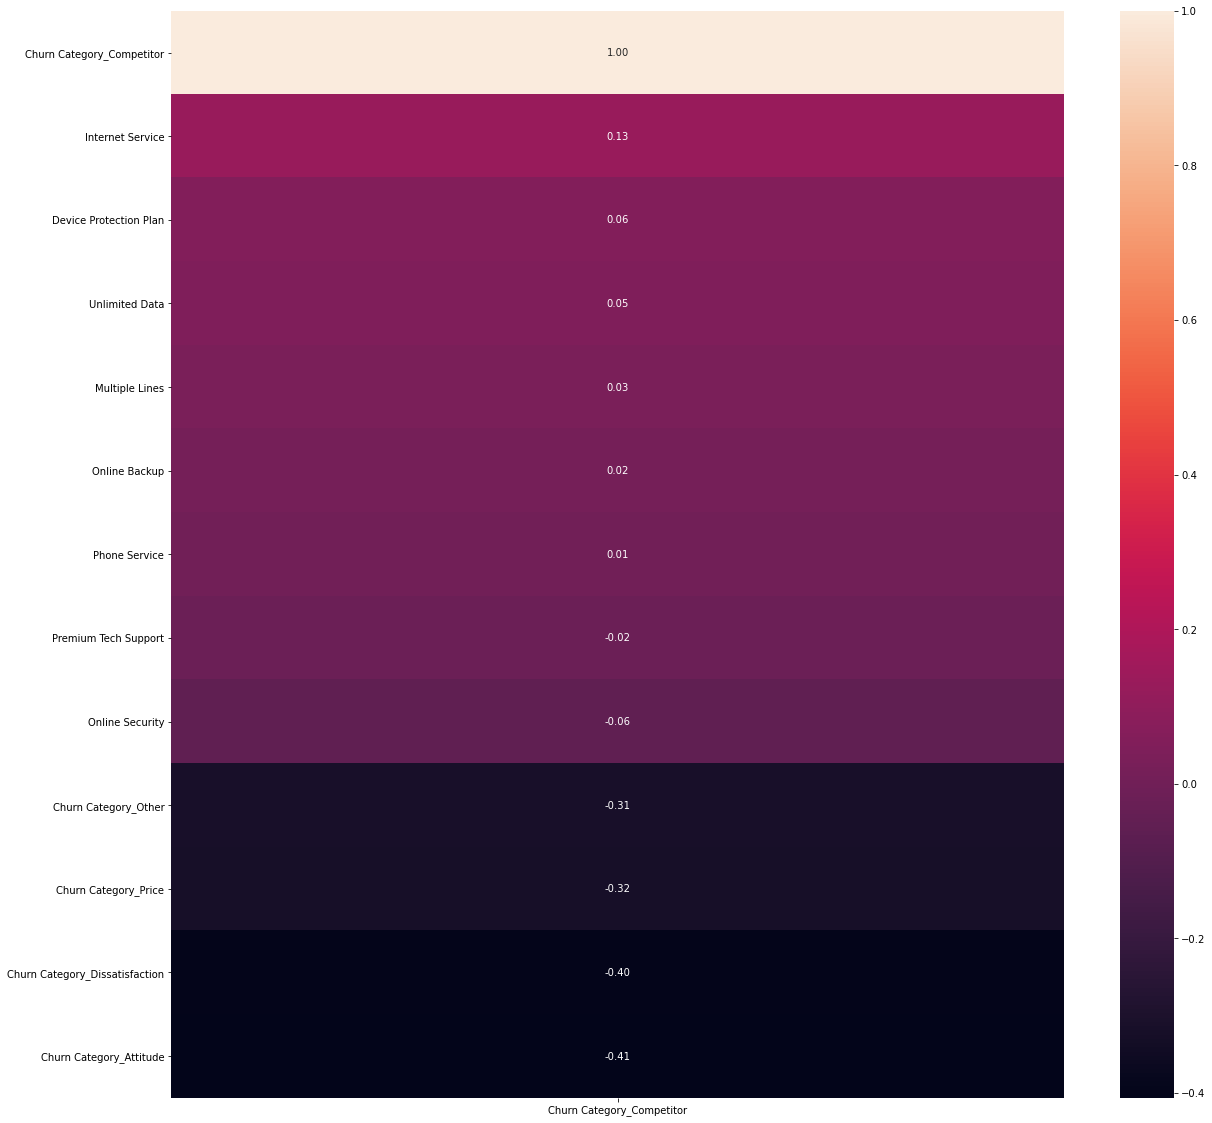

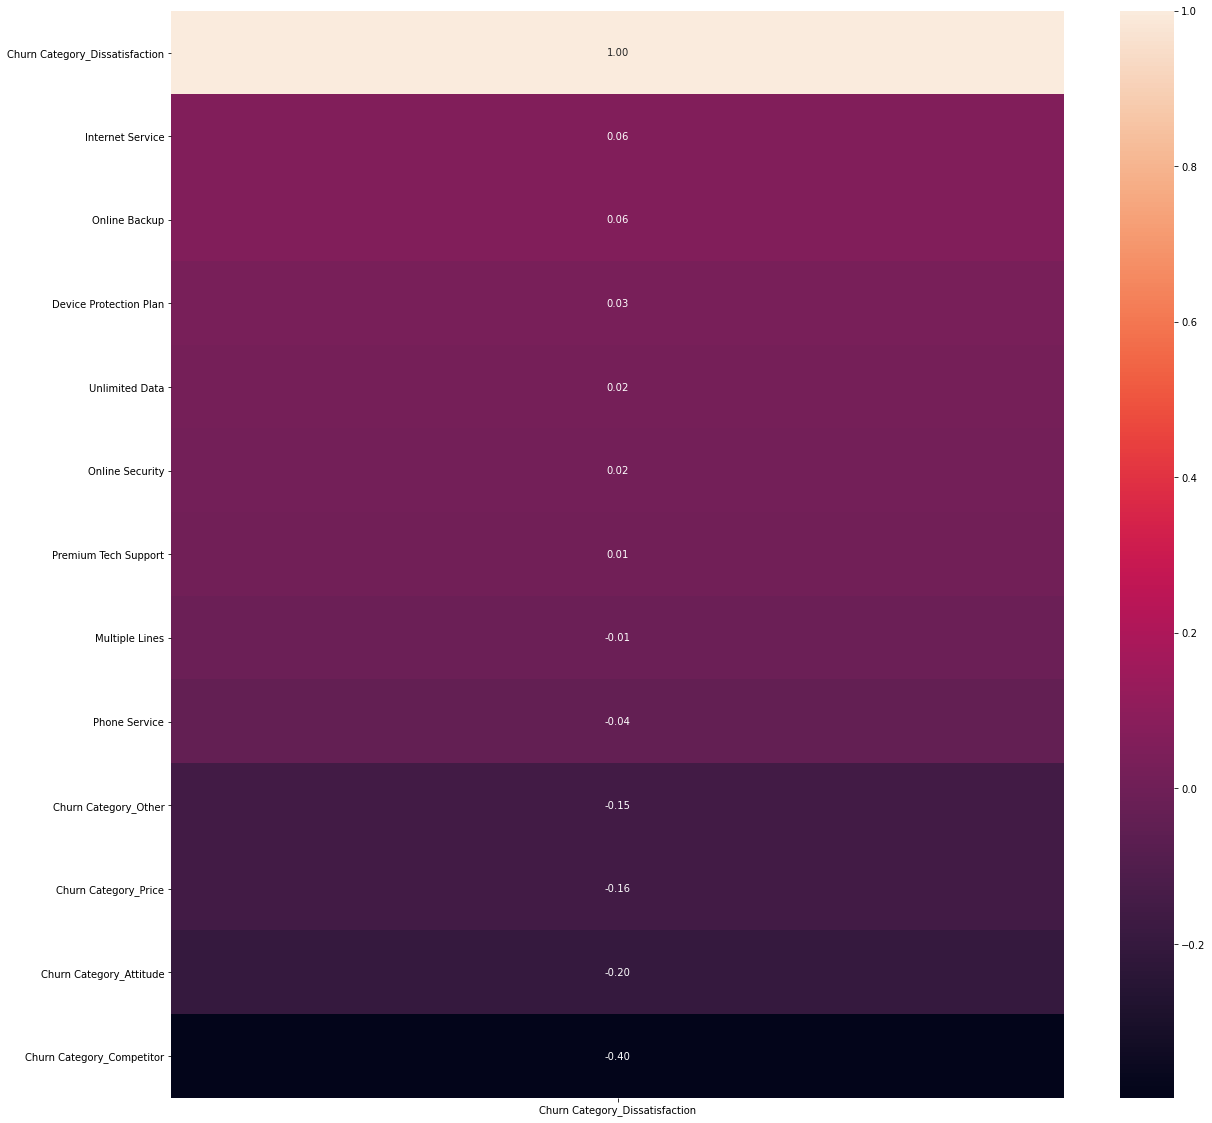

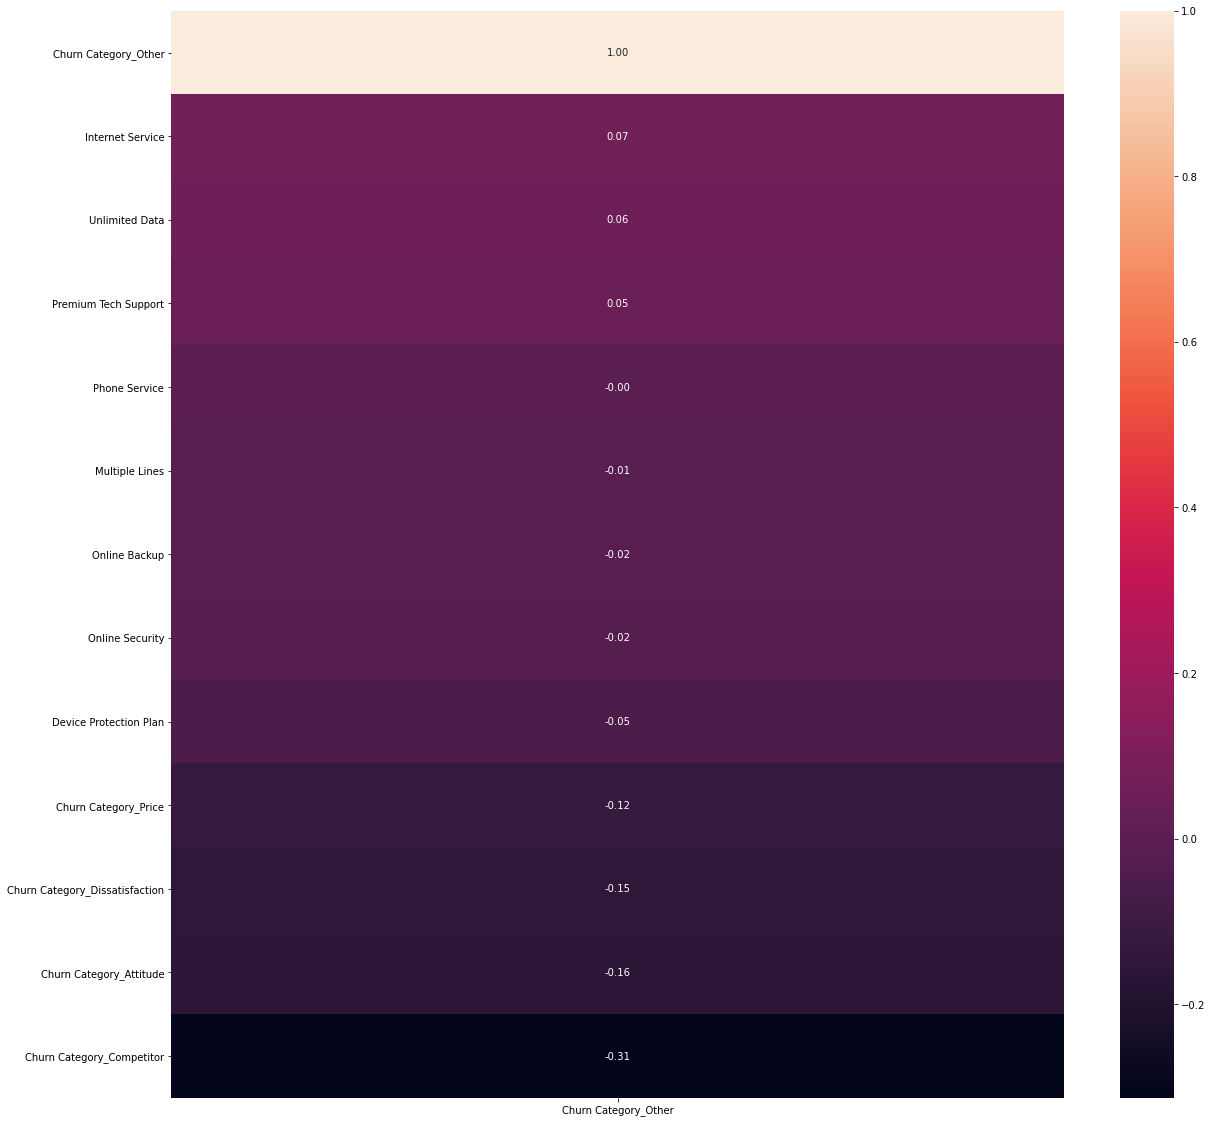

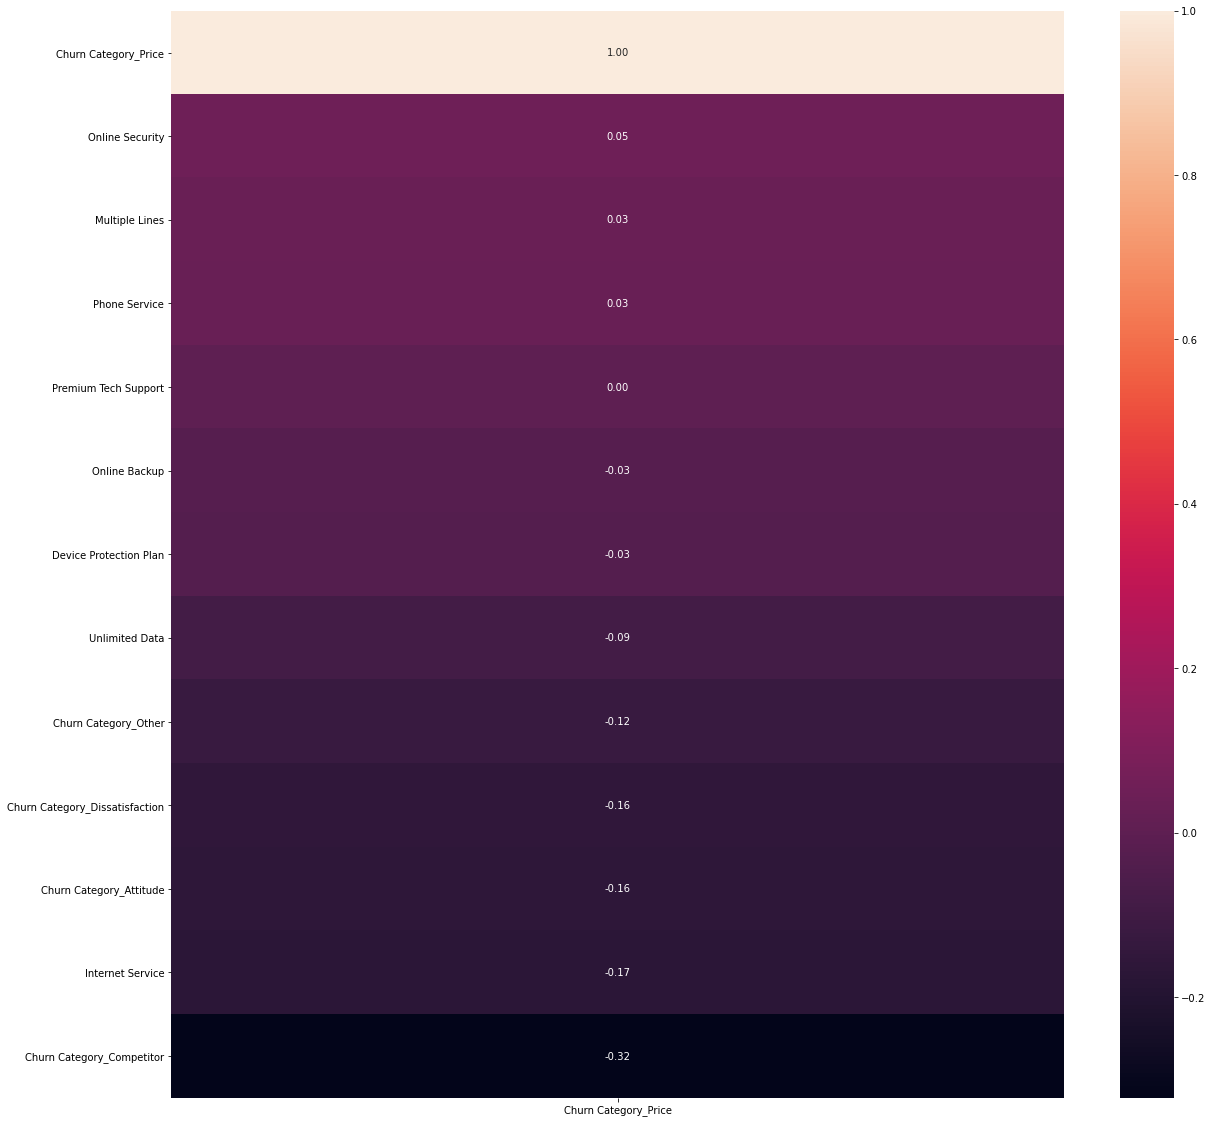

In [242]:
# visualize the correlation between the features and the target variable
plt.figure(figsize=(20, 20))
sns.heatmap(datasetCorr.corr()[['Churn Category_Attitude']].sort_values(
    by='Churn Category_Attitude', ascending=False), annot=True, fmt='.2f')
plt.show()

plt.figure(figsize=(20, 20))
sns.heatmap(datasetCorr.corr()[['Churn Category_Competitor']].sort_values(
    by='Churn Category_Competitor', ascending=False), annot=True, fmt='.2f')
plt.show()

plt.figure(figsize=(20, 20))
sns.heatmap(datasetCorr.corr()[['Churn Category_Dissatisfaction']].sort_values(
    by='Churn Category_Dissatisfaction', ascending=False), annot=True, fmt='.2f')
plt.show()


plt.figure(figsize=(20, 20))
sns.heatmap(datasetCorr.corr()[['Churn Category_Other']].sort_values(
    by='Churn Category_Other', ascending=False), annot=True, fmt='.2f')
plt.show()

plt.figure(figsize=(20, 20))
sns.heatmap(datasetCorr.corr()[['Churn Category_Price']].sort_values(
    by='Churn Category_Price', ascending=False), annot=True, fmt='.2f')
plt.show()


We need to encode the Churn Category column into numerical values so that we can use it in our model.

In [243]:
dataset['Churn Category'] = dataset['Churn Category'].map(
    {'Competitor': 0, 'Attitude': 1, 'Dissatisfaction': 2, 'Price': 3,'Other':4})

In [244]:
# split the dataset into training and testing sets
X = dataset.drop(['Churn Category'], axis=1)
y = dataset['Churn Category']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=7)


#### Model Building:

##### Logistic Regression

In [245]:
# this function takes in the model, trains it and evaluates it on the test set
# it also uses SequentialFeatureSelector to select the best features for the model
def trainModel(model, X_train, y_train, X_test, y_test):

    # get features range
    feature_range = range(1, len(X_train.columns))

    best_model_accuracy = None
    best_accuracy = 0.0
    best_model_f1 = None
    best_f1 = 0.0
    best_features = None

    # loop through all the features
    for i in feature_range:
        sfs = SequentialFeatureSelector(
            model, n_features_to_select=i, direction='forward')

        # train the model using the training sets
        sfs.fit(X_train, y_train)

        # transform the data sets so that only the selected features are retained
        X_train_sfs = sfs.transform(X_train)
        X_test_sfs = sfs.transform(X_test)

        # Print the selected features
        print("Selected Features for %d Features: %s" %
            (i, X_train.loc[:, sfs.support_].columns))

        # calculate the accuracy of the model using the test sets
        model.fit(X_train_sfs, y_train)

        # predict the response for the test sets
        y_pred = model.predict(X_test_sfs)
        #save the best model and best features based on the accuracy
        if best_accuracy < accuracy_score(y_test, y_pred):
            best_accuracy = accuracy_score(y_test, y_pred)
            best_model_accuracy = sfs
            best_features = sfs.get_support()

        #save the best model and best features based on the f1 score
        if best_f1 < f1_score(y_test, y_pred, average='weighted'):
            best_f1 = f1_score(y_test, y_pred, average='weighted')
            best_model_f1 = sfs
            best_features = sfs.get_support()

    # Print the selected features based on the accuracy
    print("Selected Features for Best Accuracy: %s" %
        (X.loc[:, best_model_accuracy.get_support()].columns))

    # Print best accuracy
    print("Best Accuracy: %f" % (best_accuracy))

    # Print the selected features based on the f1 score
    print("Selected Features for Best F1 Score: %s" %
        (X.loc[:, best_model_f1.get_support()].columns))

    # Print best f1 score
    print("Best F1 Score: %f" % (best_f1))



In [246]:
# train the model using Logistic Regression
trainModel(LogisticRegression(), X_train, y_train, X_test, y_test)

Selected Features for 1 Features: Index(['Internet Service'], dtype='object')
Selected Features for 2 Features: Index(['Internet Service', 'Multiple Lines'], dtype='object')
Selected Features for 3 Features: Index(['Phone Service', 'Internet Service', 'Multiple Lines'], dtype='object')
Selected Features for 4 Features: Index(['Phone Service', 'Internet Service', 'Multiple Lines',
       'Online Security'],
      dtype='object')
Selected Features for 5 Features: Index(['Phone Service', 'Internet Service', 'Multiple Lines',
       'Online Security', 'Online Backup'],
      dtype='object')
Selected Features for 6 Features: Index(['Phone Service', 'Internet Service', 'Multiple Lines',
       'Online Security', 'Online Backup', 'Device Protection Plan'],
      dtype='object')
Selected Features for 7 Features: Index(['Phone Service', 'Internet Service', 'Multiple Lines',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support'],
      dtype='object')

In [247]:
# train the model using svm
trainModel(SVC(), X_train, y_train, X_test, y_test)

Selected Features for 1 Features: Index(['Internet Service'], dtype='object')
Selected Features for 2 Features: Index(['Phone Service', 'Internet Service'], dtype='object')
Selected Features for 3 Features: Index(['Phone Service', 'Internet Service', 'Online Security'], dtype='object')
Selected Features for 4 Features: Index(['Phone Service', 'Internet Service', 'Online Security',
       'Online Backup'],
      dtype='object')
Selected Features for 5 Features: Index(['Phone Service', 'Internet Service', 'Online Security', 'Online Backup',
       'Device Protection Plan'],
      dtype='object')
Selected Features for 6 Features: Index(['Phone Service', 'Internet Service', 'Online Security', 'Online Backup',
       'Device Protection Plan', 'Premium Tech Support'],
      dtype='object')
Selected Features for 7 Features: Index(['Phone Service', 'Internet Service', 'Multiple Lines',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support'],
      dt

In [248]:
# train the model using Random Forest
trainModel(RandomForestClassifier(), X_train, y_train, X_test, y_test)

Selected Features for 1 Features: Index(['Internet Service'], dtype='object')
Selected Features for 2 Features: Index(['Internet Service', 'Online Security'], dtype='object')
Selected Features for 3 Features: Index(['Phone Service', 'Internet Service', 'Online Security'], dtype='object')
Selected Features for 4 Features: Index(['Phone Service', 'Internet Service', 'Multiple Lines',
       'Online Security'],
      dtype='object')
Selected Features for 5 Features: Index(['Phone Service', 'Internet Service', 'Multiple Lines',
       'Online Security', 'Device Protection Plan'],
      dtype='object')
Selected Features for 6 Features: Index(['Phone Service', 'Internet Service', 'Multiple Lines',
       'Online Security', 'Device Protection Plan', 'Unlimited Data'],
      dtype='object')
Selected Features for 7 Features: Index(['Phone Service', 'Internet Service', 'Multiple Lines',
       'Online Security', 'Device Protection Plan', 'Premium Tech Support',
       'Unlimited Data'],
      dt

##### Results:
1. the model accuracy is very bad which is expected after what we have seen in EDA where all features hd very low correlation with the target variable. So further analysis and features should be added to the model to improve the accuracy.

In [249]:
# Load the first dataset from ../Dataset/Telco_customer_churn_services.xlsx
services = pd.read_excel('../Dataset/Telco_customer_churn_services.xlsx')

In [250]:
# Load the second dataset from ../Dataset/Telco_customer_churn.xlsx
compound = pd.read_excel('../Dataset/Telco_customer_churn.xlsx')

In [251]:
# Load the data from /Dataset/Telco_customer_churn_demographics.xlsx
demographics = pd.read_excel(
    '../Dataset/Telco_customer_churn_demographics.xlsx')

In [252]:
# rename the column to match the column name in the dataset
compound.rename(columns={'CustomerID': 'Customer ID'}, inplace=True)

In [253]:
# Join the two datasets on the column 'Customer ID'
dataset1 = pd.merge(demographics, compound, on='Customer ID')

In [254]:
# check the data types of the columns
dataset1.dtypes

Customer ID              object
Count_x                   int64
Gender_x                 object
Age                       int64
Under 30                 object
Senior Citizen_x         object
Married                  object
Dependents_x             object
Number of Dependents      int64
Count_y                   int64
Country                  object
State                    object
City                     object
Zip Code                  int64
Lat Long                 object
Latitude                float64
Longitude               float64
Gender_y                 object
Senior Citizen_y         object
Partner                  object
Dependents_y             object
Tenure Months             int64
Phone Service            object
Multiple Lines           object
Internet Service         object
Online Security          object
Online Backup            object
Device Protection        object
Tech Support             object
Streaming TV             object
Streaming Movies         object
Contract

In [255]:
my_columns = ['Gender_x', 'Age', 'Married',
              'Number of Dependents', 'Churn Value', 'Tenure Months', 'Churn Score', 'Monthly Charges', 'Customer ID']

dataset1 = dataset1[my_columns]

In [256]:
dataset = pd.merge(services, dataset1, on='Customer ID')

In [257]:
dataset.dtypes

Customer ID                           object
Count                                  int64
Quarter                               object
Referred a Friend                     object
Number of Referrals                    int64
Tenure in Months                       int64
Offer                                 object
Phone Service                         object
Avg Monthly Long Distance Charges    float64
Multiple Lines                        object
Internet Service                      object
Internet Type                         object
Avg Monthly GB Download                int64
Online Security                       object
Online Backup                         object
Device Protection Plan                object
Premium Tech Support                  object
Streaming TV                          object
Streaming Movies                      object
Streaming Music                       object
Unlimited Data                        object
Contract                              object
Paperless 

In [258]:
my_columns += ['Phone Service', 'Internet Service', 'Multiple Lines',
               'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 'Unlimited Data', 'Total Revenue', 'Referred a Friend']

dataset = dataset[my_columns]

In [259]:
dataset.dtypes

Gender_x                   object
Age                         int64
Married                    object
Number of Dependents        int64
Churn Value                 int64
Tenure Months               int64
Churn Score                 int64
Monthly Charges           float64
Customer ID                object
Phone Service              object
Internet Service           object
Multiple Lines             object
Online Security            object
Online Backup              object
Device Protection Plan     object
Premium Tech Support       object
Unlimited Data             object
Total Revenue             float64
Referred a Friend          object
dtype: object

In [260]:
# rename Gender_x to gender
dataset.rename(columns={'Gender_x' : 'Gender'},inplace=True)

In [261]:
dataset.dtypes

Gender                     object
Age                         int64
Married                    object
Number of Dependents        int64
Churn Value                 int64
Tenure Months               int64
Churn Score                 int64
Monthly Charges           float64
Customer ID                object
Phone Service              object
Internet Service           object
Multiple Lines             object
Online Security            object
Online Backup              object
Device Protection Plan     object
Premium Tech Support       object
Unlimited Data             object
Total Revenue             float64
Referred a Friend          object
dtype: object

In [262]:
status = pd.read_excel('../Dataset/Telco_customer_churn_status.xlsx')

In [263]:
status.dtypes

Customer ID           object
Count                  int64
Quarter               object
Satisfaction Score     int64
Customer Status       object
Churn Label           object
Churn Value            int64
Churn Score            int64
CLTV                   int64
Churn Category        object
Churn Reason          object
dtype: object

In [264]:
columns = ['Customer ID', 'Satisfaction Score', 'CLTV']
status1 = status[columns]

In [265]:
dataset = pd.merge(dataset, status1, on='Customer ID')

In [266]:
dataset.dtypes

Gender                     object
Age                         int64
Married                    object
Number of Dependents        int64
Churn Value                 int64
Tenure Months               int64
Churn Score                 int64
Monthly Charges           float64
Customer ID                object
Phone Service              object
Internet Service           object
Multiple Lines             object
Online Security            object
Online Backup              object
Device Protection Plan     object
Premium Tech Support       object
Unlimited Data             object
Total Revenue             float64
Referred a Friend          object
Satisfaction Score          int64
CLTV                        int64
dtype: object

In [267]:
Customer_ID = dataset['Customer ID']
if 'Customer ID' in dataset.columns:
    dataset.drop('Customer ID', axis=1, inplace=True)

In [268]:
dataset = pd.get_dummies(dataset,drop_first=True)

In [269]:
dataset.head()

,Age,Number of Dependents,Churn Value,Tenure Months,Churn Score,Monthly Charges,Total Revenue,Satisfaction Score,CLTV,Gender_Male,Married_Yes,Phone Service_Yes,Internet Service_Yes,Multiple Lines_Yes,Online Security_Yes,Online Backup_Yes,Device Protection Plan_Yes,Premium Tech Support_Yes,Unlimited Data_Yes,Referred a Friend_Yes
0,78,0,1,1,100,39.65,59.65,3,5433,1,0,0,1,0,0,0,1,0,0,0
1,74,1,1,8,69,80.65,1024.10,3,5302,0,1,1,1,1,0,1,0,0,1,1
2,71,3,1,18,81,95.45,1910.88,2,3179,1,0,1,1,1,0,0,0,0,1,0
3,78,1,1,25,88,98.50,2995.07,2,5337,0,1,1,1,0,0,1,1,0,1,1
4,80,1,1,37,67,76.50,3102.36,2,2793,0,1,1,1,1,0,0,0,0,1,1


In [270]:
if 'Married_Yes' in dataset.columns:
    dataset.rename(columns={'Married_Yes':'Married','Gender_Male': 'Gender','Phone Service_Yes':'Phone Service', 'Internet Service_Yes':'Internet Service', 'Multiple Lines_Yes':'Multiple Lines',
                        'Online Security_Yes':'Online Security', 'Online Backup_Yes':'Online Backup','Device Protection Plan_Yes':'Device Protection Plan',
                        'Premium Tech Support_Yes':'Premium Tech Support','Unlimited Data_Yes':'Unlimited Data','Referred a Friend_Yes':'Referred a Friend'}, inplace=True)

In [271]:
dataset.head()

,Age,Number of Dependents,Churn Value,Tenure Months,Churn Score,Monthly Charges,Total Revenue,Satisfaction Score,CLTV,Gender,Married,Phone Service,Internet Service,Multiple Lines,Online Security,Online Backup,Device Protection Plan,Premium Tech Support,Unlimited Data,Referred a Friend
0,78,0,1,1,100,39.65,59.65,3,5433,1,0,0,1,0,0,0,1,0,0,0
1,74,1,1,8,69,80.65,1024.10,3,5302,0,1,1,1,1,0,1,0,0,1,1
2,71,3,1,18,81,95.45,1910.88,2,3179,1,0,1,1,1,0,0,0,0,1,0
3,78,1,1,25,88,98.50,2995.07,2,5337,0,1,1,1,0,0,1,1,0,1,1
4,80,1,1,37,67,76.50,3102.36,2,2793,0,1,1,1,1,0,0,0,0,1,1


In [272]:
columns = ['Customer ID', 'Churn Category']

status2 = status[columns]

In [273]:
# merge the two datasets
dataset['Customer ID'] = Customer_ID
dataset = pd.merge(dataset, status2, on='Customer ID')

In [274]:
if 'Customer ID' in dataset.columns:
    dataset.drop('Customer ID', axis=1, inplace=True)

In [275]:
datasetCorr = pd.get_dummies(dataset)

In [276]:
datasetCorr.head()

,Age,Number of Dependents,Churn Value,Tenure Months,Churn Score,Monthly Charges,Total Revenue,Satisfaction Score,CLTV,Gender,...,Online Backup,Device Protection Plan,Premium Tech Support,Unlimited Data,Referred a Friend,Churn Category_Attitude,Churn Category_Competitor,Churn Category_Dissatisfaction,Churn Category_Other,Churn Category_Price
0,78,0,1,1,100,39.65,59.65,3,5433,1,...,0,1,0,0,0,0,1,0,0,0
1,74,1,1,8,69,80.65,1024.10,3,5302,0,...,1,0,0,1,1,0,1,0,0,0
2,71,3,1,18,81,95.45,1910.88,2,3179,1,...,0,0,0,1,0,0,1,0,0,0
3,78,1,1,25,88,98.50,2995.07,2,5337,0,...,1,1,0,1,1,0,0,1,0,0
4,80,1,1,37,67,76.50,3102.36,2,2793,0,...,0,0,0,1,1,0,0,0,0,1


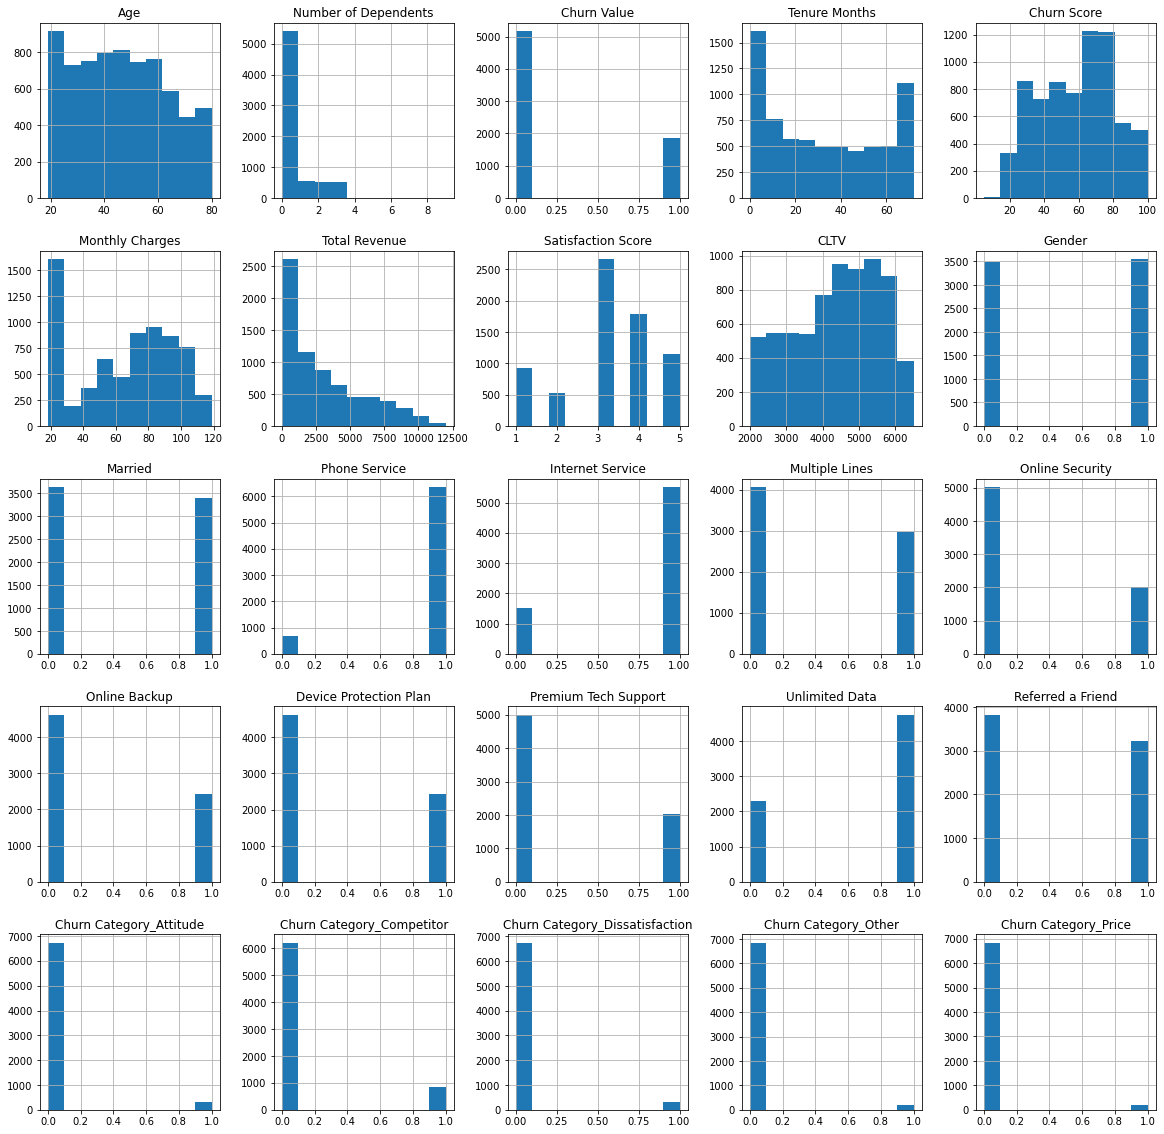

In [277]:
#visualize the distribution of the all features in the dataset
datasetCorr.hist(figsize=(20, 20))
plt.show()

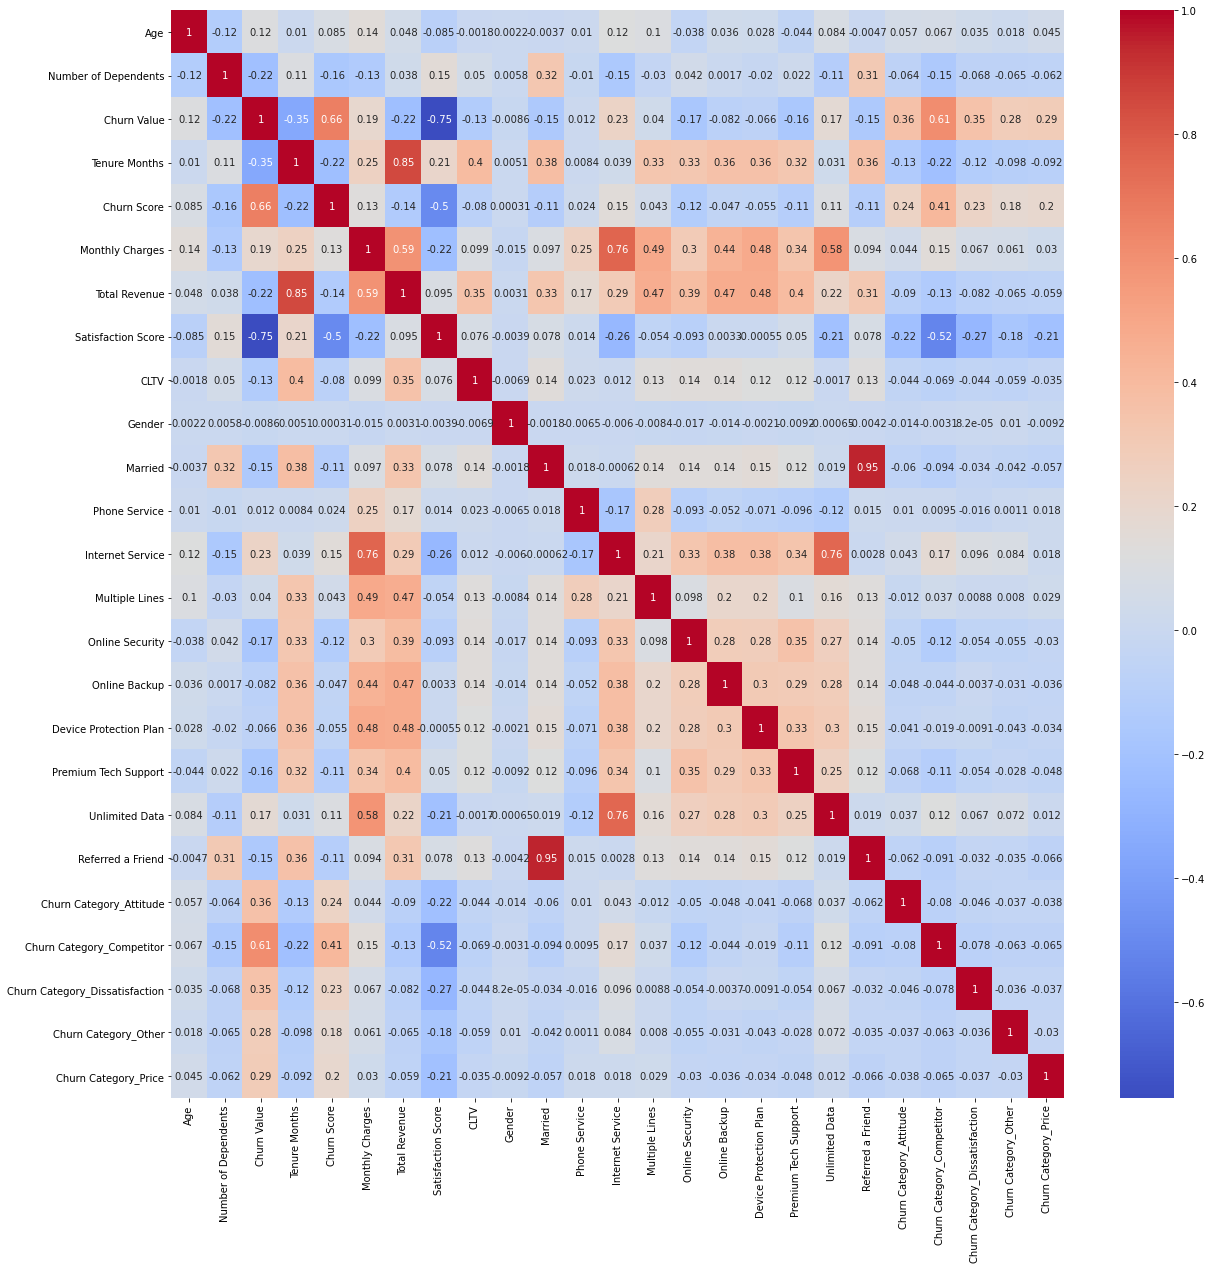

In [278]:
#visualize the correlation between the features
plt.figure(figsize=(20, 20))
sns.heatmap(datasetCorr.corr(), annot=True, cmap='coolwarm')
plt.show()


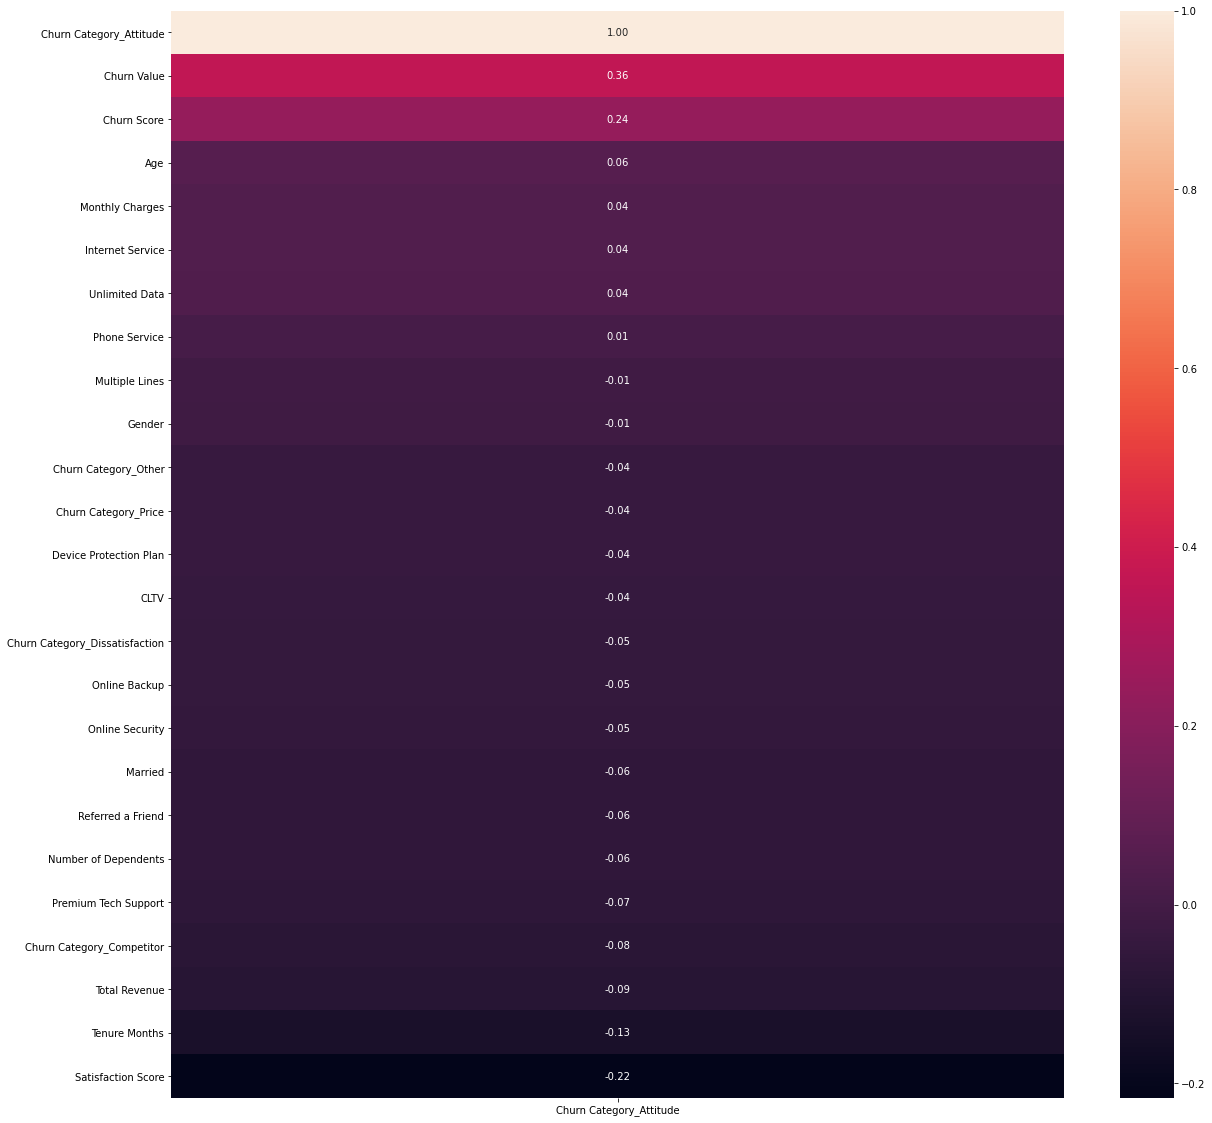

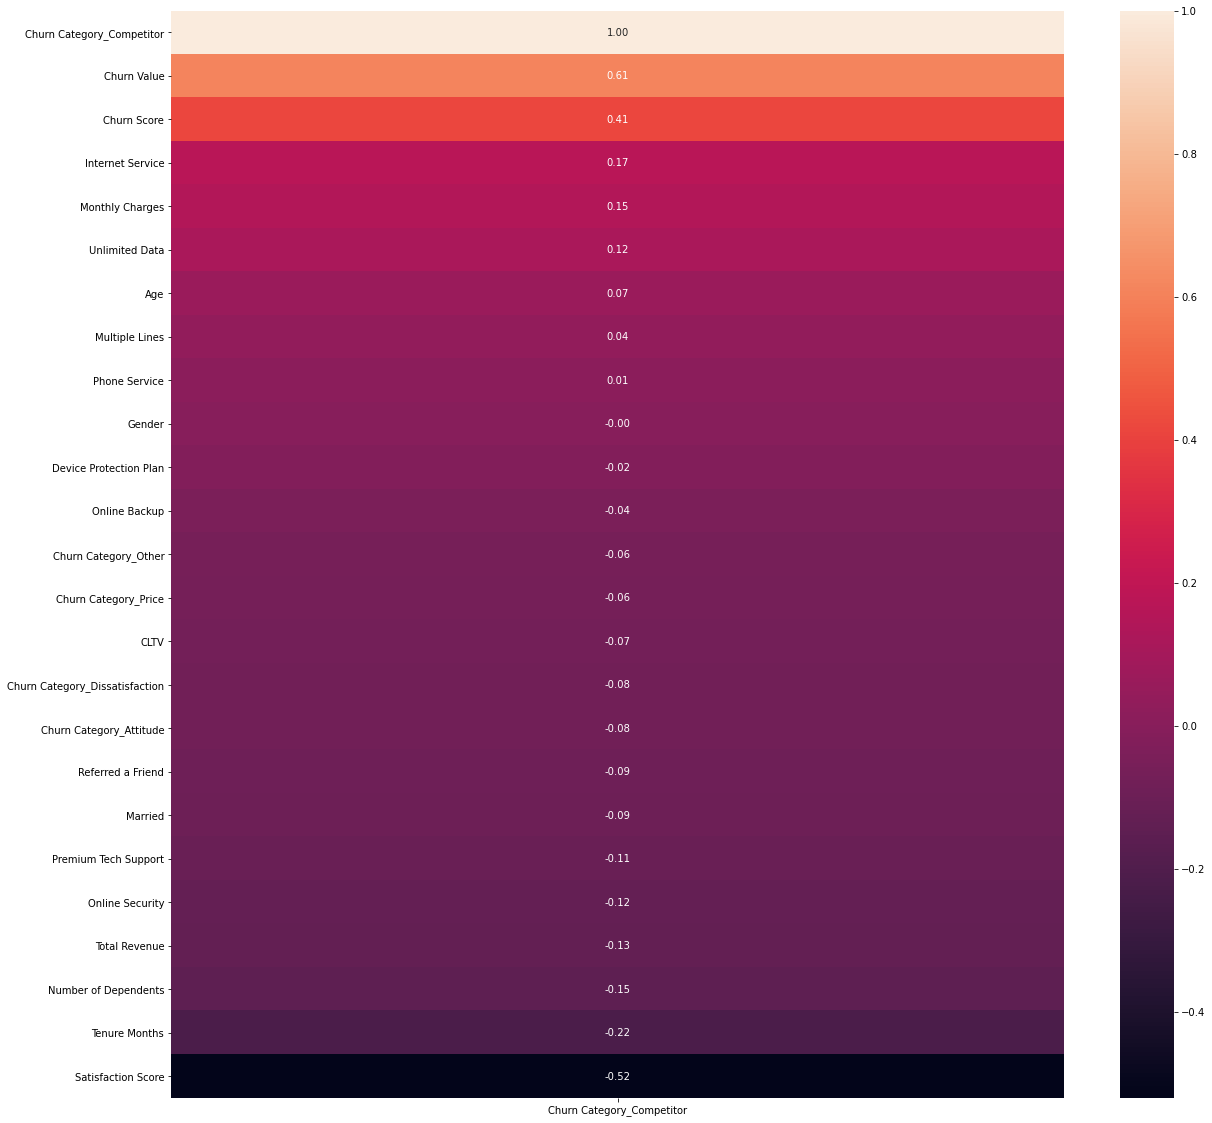

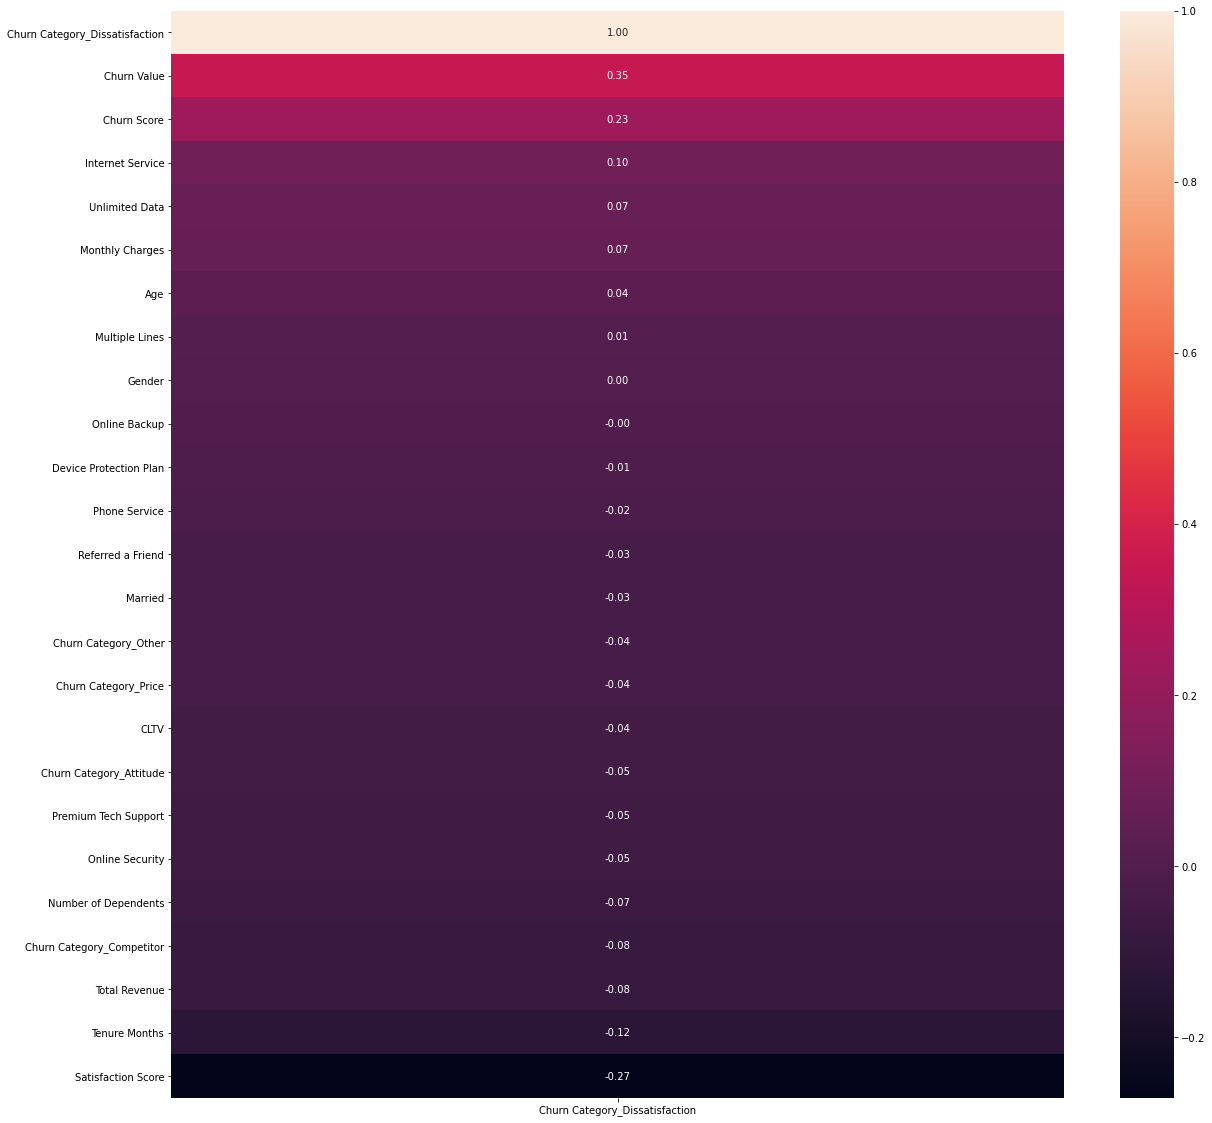

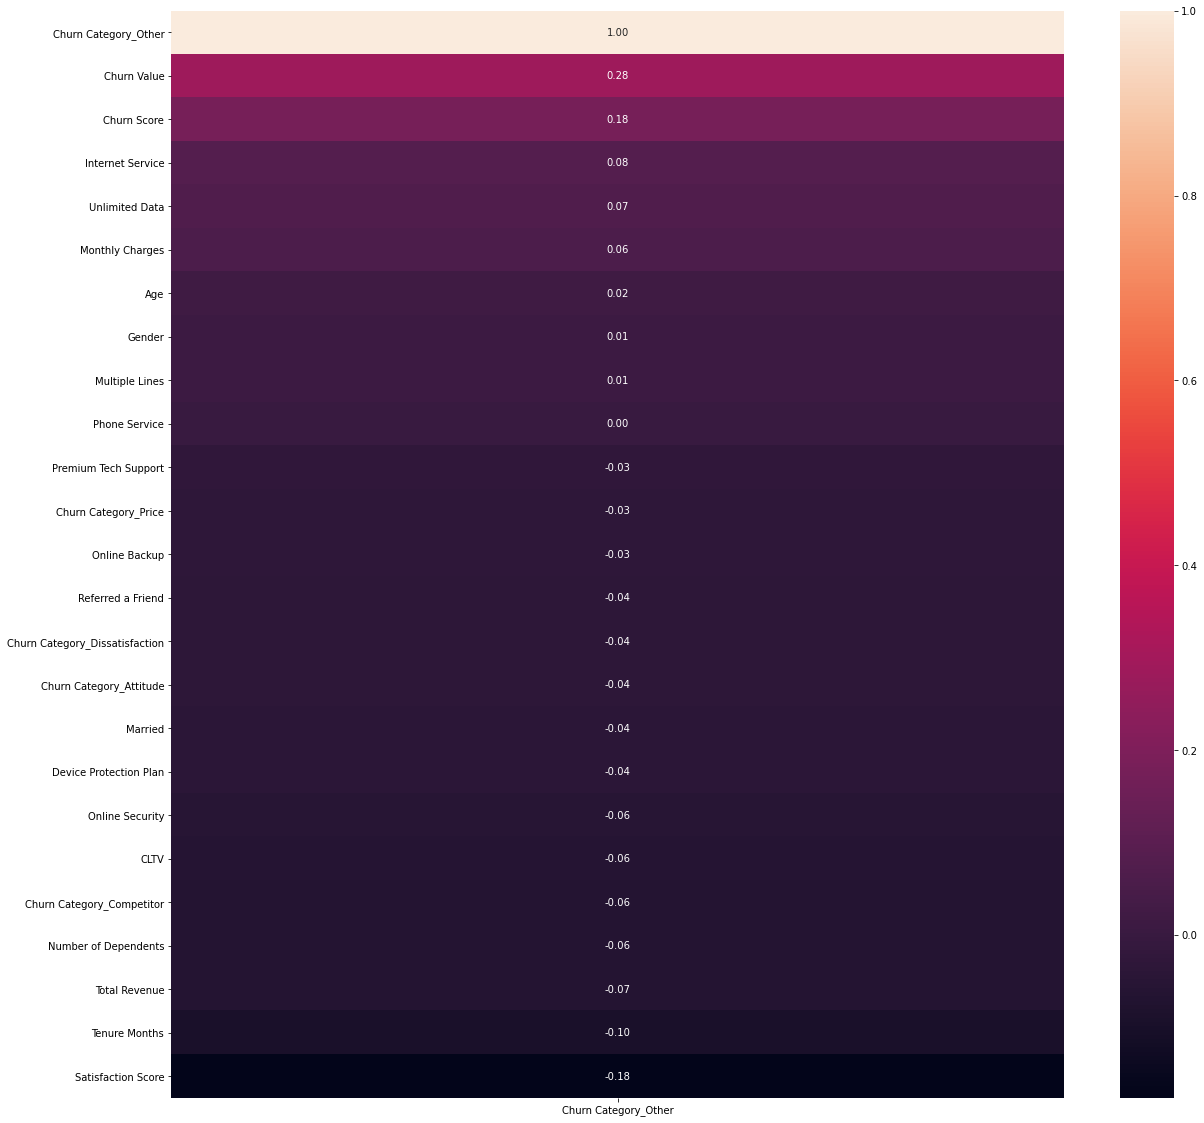

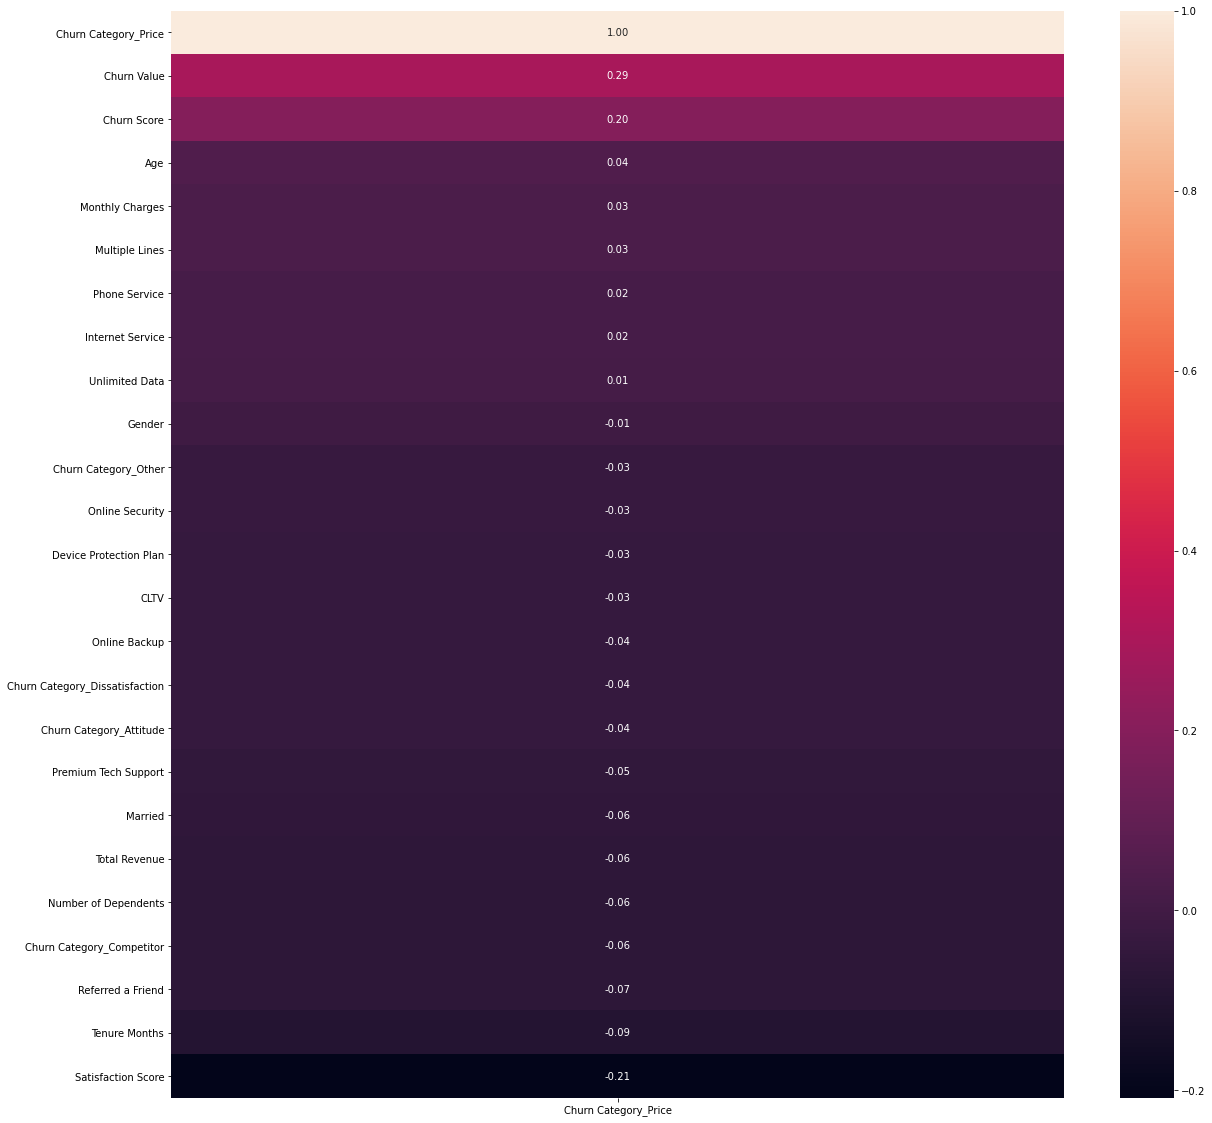

In [279]:
# visualize the correlation between the features and the target variable
plt.figure(figsize=(20, 20))
sns.heatmap(datasetCorr.corr()[['Churn Category_Attitude']].sort_values(
    by='Churn Category_Attitude', ascending=False), annot=True, fmt='.2f')
plt.show()

plt.figure(figsize=(20, 20))
sns.heatmap(datasetCorr.corr()[['Churn Category_Competitor']].sort_values(
    by='Churn Category_Competitor', ascending=False), annot=True, fmt='.2f')
plt.show()

plt.figure(figsize=(20, 20))
sns.heatmap(datasetCorr.corr()[['Churn Category_Dissatisfaction']].sort_values(
    by='Churn Category_Dissatisfaction', ascending=False), annot=True, fmt='.2f')
plt.show()


plt.figure(figsize=(20, 20))
sns.heatmap(datasetCorr.corr()[['Churn Category_Other']].sort_values(
    by='Churn Category_Other', ascending=False), annot=True, fmt='.2f')
plt.show()

plt.figure(figsize=(20, 20))
sns.heatmap(datasetCorr.corr()[['Churn Category_Price']].sort_values(
    by='Churn Category_Price', ascending=False), annot=True, fmt='.2f')
plt.show()

In [280]:
# split the dataset into training and testing sets
# get all rows with no missing values in the Churn Category column
dataset = dataset[dataset['Churn Category'].notna()]
# drop columns that have very low correlation with the target variable as in the previous analysis
# drop all services columns
columns = ['Phone Service', 'Internet Service', 'Multiple Lines', 'Online Security', 'Online Backup', 'Device Protection Plan','Premium Tech Support', 'Unlimited Data', 'Referred a Friend', 'Churn Value', 'Churn Score']
dataset.drop(columns, axis=1, inplace=True)
X = dataset.drop(['Churn Category'], axis=1)
y = dataset['Churn Category'].map({'Attitude': 0, 'Competitor': 1, 'Dissatisfaction': 2, 'Other': 3, 'Price': 4})
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=7)


In [281]:
# train the model using Logistic Regression
trainModel(LogisticRegression(), X_train, y_train, X_test, y_test)

Selected Features for 1 Features: Index(['Age'], dtype='object')


c:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_resu

Selected Features for 2 Features: Index(['Age', 'Tenure Months'], dtype='object')


c:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_resu

Selected Features for 3 Features: Index(['Age', 'Tenure Months', 'Monthly Charges'], dtype='object')


c:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_resu

Selected Features for 4 Features: Index(['Age', 'Tenure Months', 'Monthly Charges', 'Satisfaction Score'], dtype='object')


c:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_resu

Selected Features for 5 Features: Index(['Age', 'Tenure Months', 'Monthly Charges', 'Satisfaction Score',
       'Married'],
      dtype='object')


c:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_resu

Selected Features for 6 Features: Index(['Age', 'Tenure Months', 'Monthly Charges', 'Satisfaction Score',
       'Gender', 'Married'],
      dtype='object')


c:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_resu

Selected Features for 7 Features: Index(['Age', 'Number of Dependents', 'Tenure Months', 'Monthly Charges',
       'Satisfaction Score', 'Gender', 'Married'],
      dtype='object')


c:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_resu

Selected Features for 8 Features: Index(['Age', 'Number of Dependents', 'Tenure Months', 'Monthly Charges',
       'Total Revenue', 'Satisfaction Score', 'Gender', 'Married'],
      dtype='object')
Selected Features for Best Accuracy: Index(['Age', 'Tenure Months', 'Monthly Charges', 'Satisfaction Score',
       'Married'],
      dtype='object')
Best Accuracy: 0.438503
Selected Features for Best F1 Score: Index(['Age', 'Tenure Months', 'Monthly Charges', 'Satisfaction Score',
       'Married'],
      dtype='object')
Best F1 Score: 0.301965


In [282]:
# train the model using Random Forest Classifier
trainModel(RandomForestClassifier(), X_train, y_train, X_test, y_test)

Selected Features for 1 Features: Index(['Satisfaction Score'], dtype='object')
Selected Features for 2 Features: Index(['Satisfaction Score', 'Gender'], dtype='object')
Selected Features for 3 Features: Index(['Number of Dependents', 'Satisfaction Score', 'Gender'], dtype='object')
Selected Features for 4 Features: Index(['Number of Dependents', 'Satisfaction Score', 'Gender', 'Married'], dtype='object')
Selected Features for 5 Features: Index(['Number of Dependents', 'Tenure Months', 'Satisfaction Score', 'Gender',
       'Married'],
      dtype='object')
Selected Features for 6 Features: Index(['Number of Dependents', 'Tenure Months', 'Satisfaction Score', 'CLTV',
       'Gender', 'Married'],
      dtype='object')
Selected Features for 7 Features: Index(['Number of Dependents', 'Tenure Months', 'Monthly Charges',
       'Satisfaction Score', 'CLTV', 'Gender', 'Married'],
      dtype='object')
Selected Features for 8 Features: Index(['Age', 'Number of Dependents', 'Tenure Months', 'M

In [283]:
# train the model using Support Vector Classifier
trainModel(SVC(), X_train, y_train, X_test, y_test)

Selected Features for 1 Features: Index(['Age'], dtype='object')
Selected Features for 2 Features: Index(['Age', 'Number of Dependents'], dtype='object')
Selected Features for 3 Features: Index(['Age', 'Number of Dependents', 'Tenure Months'], dtype='object')
Selected Features for 4 Features: Index(['Age', 'Number of Dependents', 'Tenure Months', 'Monthly Charges'], dtype='object')
Selected Features for 5 Features: Index(['Age', 'Number of Dependents', 'Tenure Months', 'Monthly Charges',
       'Total Revenue'],
      dtype='object')
Selected Features for 6 Features: Index(['Age', 'Number of Dependents', 'Tenure Months', 'Monthly Charges',
       'Total Revenue', 'Satisfaction Score'],
      dtype='object')
Selected Features for 7 Features: Index(['Age', 'Number of Dependents', 'Tenure Months', 'Monthly Charges',
       'Total Revenue', 'Satisfaction Score', 'CLTV'],
      dtype='object')
Selected Features for 8 Features: Index(['Age', 'Number of Dependents', 'Tenure Months', 'Monthly 

##### Results:
It's very hard to predict the churn category based on any feature.